## Student ID
>> `Zeynab Mottaqi`

>> `99206203`

In [ ]:
'''

Packages

'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torchmetrics import Accuracy
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns


In [ ]:
Data = pd.read_csv('international_matches.csv')
Data[-10:]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


In [ ]:
Encoder = preprocessing.LabelEncoder()
Encoder.fit(Data['home_team_result'].values)
Results = Encoder.transform(Data['home_team_result'].values).reshape(-1,)
Data['home_team_result'] = Results
Colors = list(np.zeros_like(Results).reshape(-1,))
for i in range(len(Results)):
    if Results[i] == 0:
        Colors[i] = "green" # Draw
    elif Results[i] == 1:
        Colors[i] = "red" # Draw
    else:
        Colors[i] = "blue" # Win

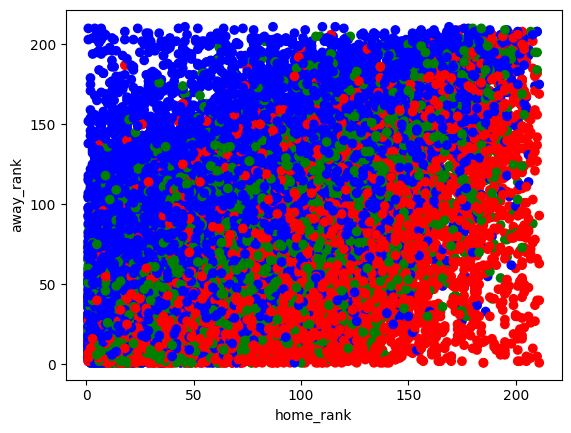

In [ ]:
plt.scatter(Data['home_team_fifa_rank'].values,Data['away_team_fifa_rank'].values,\
    c=Colors)
plt.xlabel("home_rank")
plt.ylabel("away_rank")
plt.show()

In [ ]:
def Data_to_Categorical(x, categs=None):
    if not categs:
        categs = np.amax(x) + 1
    
    Encodes = np.zeros((x.shape[0],categs))
    Encodes[np.arange(x.shape[0]),x] = 1
    return Encodes 


In [ ]:
tmp = Data[['home_team_total_fifa_points','away_team_total_fifa_points',\
    'home_team_fifa_rank','away_team_fifa_rank','home_team_result']] 

tmp = tmp.where(tmp != 0)
NewData = tmp.dropna()

In [ ]:
A = Data_to_Categorical(NewData['home_team_result'].values.astype("int"))


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

<AxesSubplot: >

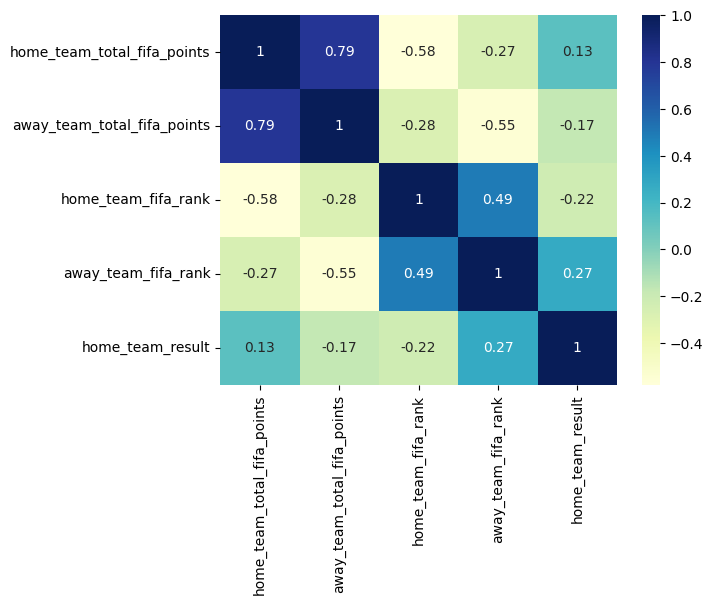

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(NewData[['home_team_fifa_rank','away_team_fifa_rank']].values,\
    A,test_size=0.25)

sns.heatmap(NewData.corr(),cmap="YlGnBu", annot=True)

In [ ]:
# Rearrange the data to torch data
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_train.shape

torch.Size([5566, 2])

In [ ]:
class Network(nn.Module):
    def __init__(self,D_In,D_Out):
        super().__init__()
        self.Layer1 = nn.Linear(in_features=D_In,out_features=10)
        self.Layer2 = nn.Linear(in_features=10,out_features=20)
        self.Layer3 = nn.Linear(in_features=20,out_features=8)
        self.Layer4 = nn.Linear(in_features=8,out_features=D_Out)

    def Forward(self,x):
        x = nn.functional.relu(self.Layer1(x))
        x = nn.functional.relu(self.Layer2(x))
        x = nn.functional.relu(self.Layer3(x))
        x = self.Layer4(x)
        return x
    
D_In,D_Out = 2,3
epochs = 5000
Model = Network(D_In=D_In,D_Out=D_Out)

Loss = nn.MSELoss()
Optimizer = torch.optim.SGD(Model.parameters(),lr=1e-4)

for i in range(epochs):
    Optimizer.zero_grad()
    Prediction = Model.Forward(X_train)
    Probs = nn.Softmax(dim=1)(Prediction)
    loss = Loss(Probs,torch.Tensor(y_train))
    accuracy = np.sum(Prediction.argmax(1).numpy() == y_train.argmax(1),axis=0)/len(y_train)

    if (i+1)%50 == 0:
        print(f"At {i+1}/{epochs} iteration the Loss is {loss.item():2.3E}, and accuracy is {accuracy:2.2f}% .")

    loss.backward()
    Optimizer.step()

# Testing

Pred_Test = Model.Forward(torch.Tensor(X_test))
Prob_Test = nn.Softmax(dim=1)(Pred_Test)
Error = Loss(Prob_Test,torch.Tensor(y_test))
Test_Acc = np.sum(Pred_Test.argmax(1).numpy() == y_test.argmax(1),axis=0)/len(y_test)
print(f"\n Test Error is {Error.item():2.3E}, and Test accuracy is {Test_Acc:2.2f}%.")


At 50/5000 iteration the Loss is 2.032E-01, and accuracy is 0.51% .
At 100/5000 iteration the Loss is 1.992E-01, and accuracy is 0.51% .
At 150/5000 iteration the Loss is 1.956E-01, and accuracy is 0.52% .
At 200/5000 iteration the Loss is 1.924E-01, and accuracy is 0.53% .
At 250/5000 iteration the Loss is 1.896E-01, and accuracy is 0.53% .
At 300/5000 iteration the Loss is 1.872E-01, and accuracy is 0.53% .
At 350/5000 iteration the Loss is 1.850E-01, and accuracy is 0.53% .
At 400/5000 iteration the Loss is 1.832E-01, and accuracy is 0.54% .
At 450/5000 iteration the Loss is 1.815E-01, and accuracy is 0.54% .
At 500/5000 iteration the Loss is 1.800E-01, and accuracy is 0.54% .
At 550/5000 iteration the Loss is 1.786E-01, and accuracy is 0.55% .
At 600/5000 iteration the Loss is 1.774E-01, and accuracy is 0.55% .
At 650/5000 iteration the Loss is 1.762E-01, and accuracy is 0.55% .
At 700/5000 iteration the Loss is 1.751E-01, and accuracy is 0.56% .
At 750/5000 iteration the Loss is 1

In [ ]:
class Modified_Network(nn.Module):
    def __init__(self,D_In,D_Hid,D_Out):
        super().__init__()
        self.Layer1 = nn.Linear(in_features=D_In,out_features=D_Hid)
        self.Drop = nn.Dropout(p=0.003)
        self.Layer2 = nn.Linear(in_features=D_Hid,out_features=D_Hid)
        self.Layer3 = nn.Linear(in_features=D_Hid,out_features=D_Hid)
        self.Layer4 = nn.Linear(in_features=D_Hid,out_features=D_Out)
    def Forward(self,x):
        x = nn.functional.relu(self.Layer1(x))
        x = self.Drop(x)
        x = nn.functional.relu(self.Layer2(x))
        x = self.Drop(x)
        x = nn.functional.relu(self.Layer3(x))
        x = self.Layer4(x)
        return x

D_In,D_Hid,D_Out = 2,80,3
epochs = 5000
Model2 = Modified_Network(D_In=D_In,D_Hid=D_Hid,D_Out=D_Out)

Loss = nn.MSELoss()
Optimizer = torch.optim.Adam(Model2.parameters(),lr=1e-4)

for i in range(epochs):
    Optimizer.zero_grad()
    Prediction = Model2.Forward(X_train)
    Probs = nn.Softmax(dim=1)(Prediction)
    loss = Loss(Probs,torch.Tensor(y_train))
    accuracy = np.sum(Prediction.argmax(1).numpy() == y_train.argmax(1),axis=0)/len(y_train)

    if (i+1)%50 == 0:
        print(f"At {i+1}/{epochs} iteration the Loss is {loss.item():2.3E}, and accuracy is {accuracy:2.2f}% . ")

    loss.backward()
    Optimizer.step()

# Testing

Pred_Test = Model2.Forward(torch.Tensor(X_test))
Prob_Test = nn.Softmax(dim=1)(Pred_Test)
Error = Loss(Prob_Test,torch.Tensor(y_test))
Test_Acc = np.sum(Pred_Test.argmax(1).numpy() == y_test.argmax(1),axis=0)/len(y_test)

print(f"Test Error is {Error.item():2.3E}, and Test accuracy is {Test_Acc:2.2f}%.")


At 50/5000 iteration the Loss is 1.215E-01, and accuracy is 0.74% . 
At 100/5000 iteration the Loss is 1.188E-01, and accuracy is 0.74% . 
At 150/5000 iteration the Loss is 1.178E-01, and accuracy is 0.74% . 
At 200/5000 iteration the Loss is 1.173E-01, and accuracy is 0.74% . 
At 250/5000 iteration the Loss is 1.167E-01, and accuracy is 0.73% . 
At 300/5000 iteration the Loss is 1.166E-01, and accuracy is 0.73% . 
At 350/5000 iteration the Loss is 1.165E-01, and accuracy is 0.74% . 
At 400/5000 iteration the Loss is 1.165E-01, and accuracy is 0.73% . 
At 450/5000 iteration the Loss is 1.156E-01, and accuracy is 0.74% . 
At 500/5000 iteration the Loss is 1.161E-01, and accuracy is 0.74% . 
At 550/5000 iteration the Loss is 1.159E-01, and accuracy is 0.73% . 
At 600/5000 iteration the Loss is 1.154E-01, and accuracy is 0.74% . 
At 650/5000 iteration the Loss is 1.153E-01, and accuracy is 0.74% . 
At 700/5000 iteration the Loss is 1.150E-01, and accuracy is 0.74% . 
At 750/5000 iteration

In [ ]:
a = Data['home_team'] == 'IR Iran'
IranData =  Data[a][['home_team_total_fifa_points','away_team_total_fifa_points',\
    'home_team_fifa_rank','away_team_fifa_rank','home_team_result']]
IranData = IranData.where(IranData!=0)
IranData = IranData.dropna()

In [ ]:
IranData

,home_team_total_fifa_points,away_team_total_fifa_points,home_team_fifa_rank,away_team_fifa_rank,home_team_result
14292,558.0,207.0,53,131,2.0
14417,576.0,108.0,50,162,2.0
14509,576.0,334.0,50,102,2.0
14894,578.0,4.0,51,202,2.0
14897,578.0,322.0,51,106,2.0
15443,548.0,776.0,58,25,2.0
15481,548.0,219.0,58,136,2.0
15507,610.0,490.0,44,69,1.0
15624,610.0,130.0,44,162,2.0
15756,536.0,252.0,60,130,2.0


In [ ]:
X_Iran = IranData[['home_team_fifa_rank','away_team_fifa_rank']].values
y_Iran = IranData['home_team_result'].values
y_Iran = Data_to_Categorical(y_Iran.astype('int'))
Pred_Iran = Model2.Forward(torch.Tensor(X_Iran))
Prob_Iran = nn.Softmax(dim=1)(Pred_Iran)
Loss_Iran = Loss(Prob_Iran,torch.Tensor(y_Iran)).item()
Acc_Iran = np.sum(Prob_Iran.argmax(1).numpy() == y_Iran.argmax(1))/len(y_Iran) 

In [ ]:
print(f"Iran wins at {Acc_Iran:2.2f}% of matches.")

Iran wins at 0.87% of matches.
